<a href="https://colab.research.google.com/github/Emtatos/Football/blob/main/52Crypto_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hämtar historisk Bitcoin-data...
Beräknar tekniska indikatorer...
Hämtar sentiment från nyhetsflöden...
Träningsdata: 3624 rader, Testdata: 90 rader
XGBClassifier: early_stopping_rounds accepteras inte – tränar utan early stopping.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:26:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1555, number of negative: 1344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2899, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536392 -> initscore=0.145825
[LightGBM] [Info] Start training from score 0.145825
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694186
Accuracy på testdata: 52.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59        47
           1       0.50      0.37      0.43        43

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.52      0.51        90


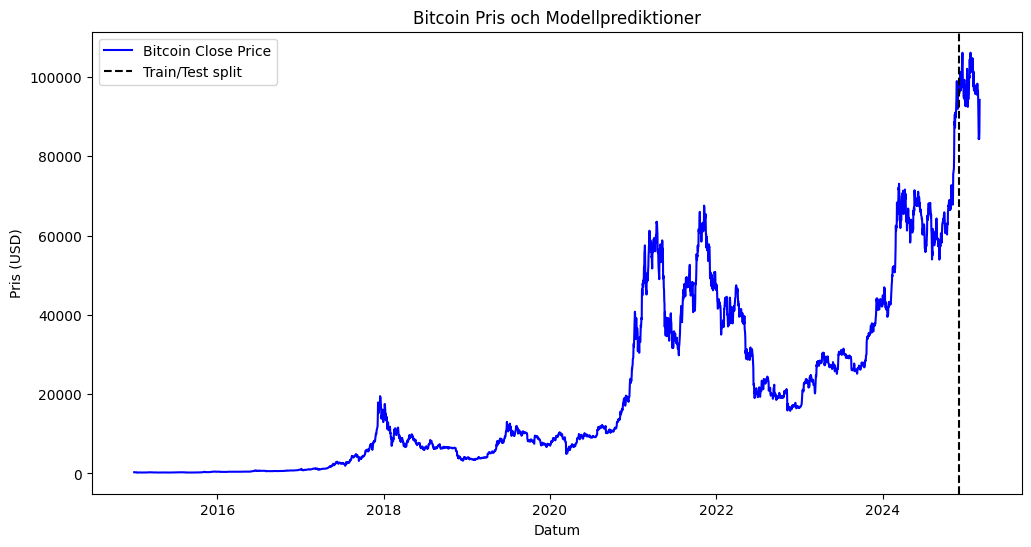

Modellens prediktion för nästa dag: Nedgång
Buy probability: 13.5%, Sell probability: 86.5%
Rekommendation: SÄLJ


In [18]:
# --- Installation av nödvändiga paket ---
!pip install yfinance ta feedparser lightgbm xgboost nltk -q

# --- Importera bibliotek ---
import pandas as pd
import numpy as np
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD
import feedparser
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Importera callback-funktioner för early stopping
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

# --- Steg 1: Hämta historisk Bitcoin-data ---
print("Hämtar historisk Bitcoin-data...")
df = yf.download('BTC-USD', start='2015-01-01', progress=False)
df.dropna(inplace=True)

# Hantera eventuellt MultiIndex i kolumnerna genom att platta ut det
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
else:
    df.columns = df.columns.str.strip()

# Säkerställ att 'Close'-data är 1-dimensionell
close_series = pd.Series(df['Close'].values.ravel(), index=df.index)

# --- Steg 2: Beräkna tekniska indikatorer ---
print("Beräknar tekniska indikatorer...")

# RSI
rsi_obj = RSIIndicator(close=close_series, window=14)
rsi_series = rsi_obj.rsi()
df['RSI'] = rsi_series

# EMA
ema_obj = EMAIndicator(close=close_series, window=20)
ema_series = ema_obj.ema_indicator()
df['EMA'] = ema_series

# MACD: Använd samma objekt för MACD, signallinje och histogram
macd_obj = MACD(close=close_series, window_fast=12, window_slow=26, window_sign=9)
df['MACD'] = macd_obj.macd()
df['MACD_signal'] = macd_obj.macd_signal()
df['MACD_hist'] = macd_obj.macd_diff()

# --- Steg 3: Hämta sentiment från RSS-nyheter och analysera med NLTK VADER ---
print("Hämtar sentiment från nyhetsflöden...")
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()
feeds = [
    'https://feeds.feedburner.com/CoinDesk',
    'https://cointelegraph.com/rss'
]
sentiments = []
for url in feeds:
    feed = feedparser.parse(url)
    for entry in feed.entries:
        if 'title' in entry:
            score = sia.polarity_scores(entry.title)['compound']
            sentiments.append(score)
avg_sentiment = np.mean(sentiments) if sentiments else 0.0

# Lägg till sentiment som en feature – vi sätter sentimentet på den senaste dagen
df['Sentiment'] = 0.0
if len(df) > 0:
    df.at[df.index[-1], 'Sentiment'] = float(avg_sentiment)

# --- Steg 4: Skapa target-variabel ---
# Target: 1 om nästa dags stängningskurs är högre än dagens, annars 0.
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
# Spara den senaste radens features (för framtida prediktion) och ta bort raden utan target
last_features = df[['RSI', 'EMA', 'MACD', 'Sentiment']].iloc[-1:].copy()
# Se till att kolumnnamnen är rena (utan extra mellanslag)
last_features.columns = last_features.columns.str.strip()
df = df.iloc[:-1]

# --- Steg 5: Dela upp data i tränings- och testmängd ---
features = ['RSI', 'EMA', 'MACD', 'Sentiment']
# För att vara extra säker på att vi har rätt namn:
X = df[features].copy()
X.columns = [col.strip() for col in X.columns]
y = df['Target']
test_size = 90  # Använd de senaste 90 dagarna som testdata
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
print(f"Träningsdata: {len(X_train)} rader, Testdata: {len(X_test)} rader")

# --- Steg 6: Definiera modeller och träna med early stopping ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Skapa XGBoost-modell – försök använda early_stopping_rounds; annars tränas utan
xgb = XGBClassifier(n_estimators=1000, random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb = LGBMClassifier(n_estimators=1000, random_state=42)
meta_model = LogisticRegression()

# Dela upp en del av träningsdata för validering (utan att blanda tidsordningen)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
try:
    xgb.fit(X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose=False)
except TypeError:
    print("XGBClassifier: early_stopping_rounds accepteras inte – tränar utan early stopping.")
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

# För LightGBM: Försök använda callback; om det inte fungerar, träna utan early stopping.
try:
    lgb.fit(X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgbm.early_stopping(stopping_rounds=50)])
except TypeError:
    print("LGBMClassifier: early_stopping callback accepteras inte – tränar utan early stopping.")
    lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

rf.fit(X_train, y_train)

# --- Steg 7: Bygg stacking-ensemble ---
stack_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgb)],
    final_estimator=meta_model,
    cv='prefit'
)
stack_model.fit(X_train, y_train)

# --- Steg 8: Utvärdera modellen ---
y_pred = stack_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy på testdata: {acc*100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- Steg 9: Visualisera resultat ---
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Bitcoin Close Price', color='blue')
plt.axvline(x=X_test.index[0], color='k', linestyle='--', label='Train/Test split')
plt.title('Bitcoin Pris och Modellprediktioner')
plt.xlabel('Datum')
plt.ylabel('Pris (USD)')
plt.legend(loc='best')
plt.show()

# --- Steg 10: Prediktera nästa dags rörelse ---
next_day_pred = stack_model.predict(last_features)[0]
prob = stack_model.predict_proba(last_features)[0]
print("Modellens prediktion för nästa dag:", "Uppgång" if next_day_pred == 1 else "Nedgång")
print(f"Buy probability: {prob[1]*100:.1f}%, Sell probability: {prob[0]*100:.1f}%")
print("Rekommendation:", "KÖP" if next_day_pred == 1 else "SÄLJ")